# Finkelstein-Schafer Method TMY and Synthetic Year(s) comparison

## FS Statistics

The following snippets are for building FS using an input dataset.

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'FMBORS_THETAO_585.csv'
# Extract the filename from the file path
filename = file_path.split('/')[-1]  # This splits the path and gets the last part
startyear, endyear = 2025, 2035
# Split the filename by underscores and get the second part
variable = filename.split('_')[1]
variable = variable.upper()
print(f"Variable name extracted: {variable}")


Variable name extracted: THETAO


In [146]:
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%Y')

ref_ts = data[(data['Date'].dt.year >= startyear) & (data['Date'].dt.year <= endyear)] #Reference timeslice, full range of years inclusive.
# print(ref_ts)

# Ensure the ref_ts dataframe is correctly extracted as shown previously
ref_ts = ref_ts.reset_index(drop=True)  # Reset index if needed

# Generate the unique ID column and assign using .loc
ref_ts.loc[:, 'ID'] = ['I' + str(i).zfill(3) for i in range(1, len(ref_ts) + 1)]

# Initialize a dictionary to hold the subsets
sub_ts = {}

# Loop through the range of years and create subsets, storing them in the dictionary
for n in range(endyear - startyear + 1):
    current_year = startyear + n
    # Creating a dictionary key for each year
    key = f"sub_ts_{current_year}"
    # Filtering data for the current year
    sub_ts[key] = ref_ts[ref_ts['Date'].dt.year == current_year].copy()


In [147]:
# Sorting ref_ts in ascending order based on the variable
sorted_ref_ts = ref_ts.sort_values(by=variable)

# Calculating the ECDF values directly using the index without resetting
n = len(sorted_ref_ts)
sorted_ref_ts['ECDF'] = (np.arange(1, n + 1)) / n
# Sorting each sub_ts in ascending order and calculate ECDF
sorted_sub_ts = {}

for year in range(startyear, endyear + 1):
    key = f"sub_ts_{year}"
    sorted_df = sub_ts[key].sort_values(by=variable)
    n = len(sorted_df)
    sorted_df['ECDF'] = np.arange(1, n + 1) / n
    sorted_sub_ts[key] = sorted_df
    

In [148]:
# Initialize an empty list to hold the flattened data
flattened_sub_ts_list = []

# Loop through each DataFrame in the sorted_sub_ts dictionary and append to the list
for key, df in sorted_sub_ts.items():
    flattened_sub_ts_list.append(df[['Date', variable, 'ID', 'ECDF']])

# Concatenate all DataFrames in the list into a single DataFrame
flattened_sub_ts = pd.concat(flattened_sub_ts_list, ignore_index=True)

# Rename the columns to match the required format
flattened_sub_ts.columns = ['Date', variable, 'ID', 'ECDF']

# Sort flattened_sub_ts by ID
sorted_flattened_sub_ts = flattened_sub_ts.sort_values(by='ID').reset_index(drop=True)

# Sort sorted_ref_ts by ID
sorted_sorted_ref_ts = sorted_ref_ts.sort_values(by='ID').reset_index(drop=True)

In [149]:
# Step 1: Rename the ECDF columns - ECDF_r for reference timeseries, ECDF_s for subset
sorted_sorted_ref_ts = sorted_sorted_ref_ts.rename(columns={'ECDF': 'ECDF_r'})
sorted_flattened_sub_ts = sorted_flattened_sub_ts.rename(columns={'ECDF': 'ECDF_s'})

# Step 2: Merge the DataFrames on the ID column
fs_calc = pd.merge(sorted_sorted_ref_ts, sorted_flattened_sub_ts[['ID', 'ECDF_s']], on='ID')
fs_calc['FS'] = (fs_calc['ECDF_r'] - fs_calc['ECDF_s']).abs()
# Step 1: Extract the month and year from the Date column
fs_calc['Month'] = fs_calc['Date'].dt.month
fs_calc['Year'] = fs_calc['Date'].dt.year

# Step 2: Sort the DataFrame by Month and then by Year
fs_calc = fs_calc.sort_values(by=['Month', 'Year']).reset_index(drop=True)


In [150]:
# Extract the month and year from the Date column
fs_calc['Month'] = fs_calc['Date'].dt.month
fs_calc['Year'] = fs_calc['Date'].dt.year

# Initialize a dictionary to hold the lowest FS for each month
lowest_fs_by_month = {}

# Step 2: Group the DataFrame by Month and find the year with the lowest FS for each month
for month in range(1, 13):  # Loop through months 1 to 12
    # Filter the data for the current month
    monthly_data = fs_calc[fs_calc['Month'] == month]
    
    # Find the minimum FS value for the month
    min_fs = monthly_data['FS'].min()
    
    # Get the rows with the minimum FS value
    min_fs_rows = monthly_data[monthly_data['FS'] == min_fs]
    
    # Extract the year(s) with the minimum FS
    years_with_min_fs = min_fs_rows['Year'].unique()
    
    # Print the result for the current month
    month_name = pd.to_datetime(month, format='%m').strftime('%B')
    print(f"{month_name}: Year(s) with the lowest FS: {', '.join(map(str, years_with_min_fs))}")

    # Store the result in the dictionary
    lowest_fs_by_month[month_name] = years_with_min_fs.tolist()


January: Year(s) with the lowest FS: 2030
February: Year(s) with the lowest FS: 2028
March: Year(s) with the lowest FS: 2035
April: Year(s) with the lowest FS: 2033
May: Year(s) with the lowest FS: 2034
June: Year(s) with the lowest FS: 2034
July: Year(s) with the lowest FS: 2027, 2033
August: Year(s) with the lowest FS: 2034
September: Year(s) with the lowest FS: 2033
October: Year(s) with the lowest FS: 2031, 2035
November: Year(s) with the lowest FS: 2030
December: Year(s) with the lowest FS: 2035


In [151]:
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
FS_YEAR = []
# Loop through each month to find the year with the lowest FS and get the corresponding THETAO value
for month in range(1, 13):  # Loop through months 1 to 12
    # Filter the data for the current month
    monthly_data = fs_calc[fs_calc['Month'] == month]
    
    # Find the minimum FS value for the month
    min_fs = monthly_data['FS'].min()
    
    # Get the row(s) with the minimum FS value
    min_fs_rows = monthly_data[monthly_data['FS'] == min_fs]
    
    # Extract the year with the minimum FS
    year_with_min_fs = min_fs_rows['Year'].iloc[0]
    
    # Extract the Data value corresponding to the year with the lowest FS
    data_value = min_fs_rows[min_fs_rows['Year'] == year_with_min_fs][variable].iloc[0]
    
    # Add the THETAO value to the list
    FS_YEAR.append(data_value)


In [152]:
FS_YEAR

[8.595776649,
 7.368971214,
 7.379054973,
 9.692564406,
 12.60505144,
 15.64490912,
 17.73162836,
 19.60548998,
 18.49173684,
 16.54850858,
 13.71392046,
 10.81377836]

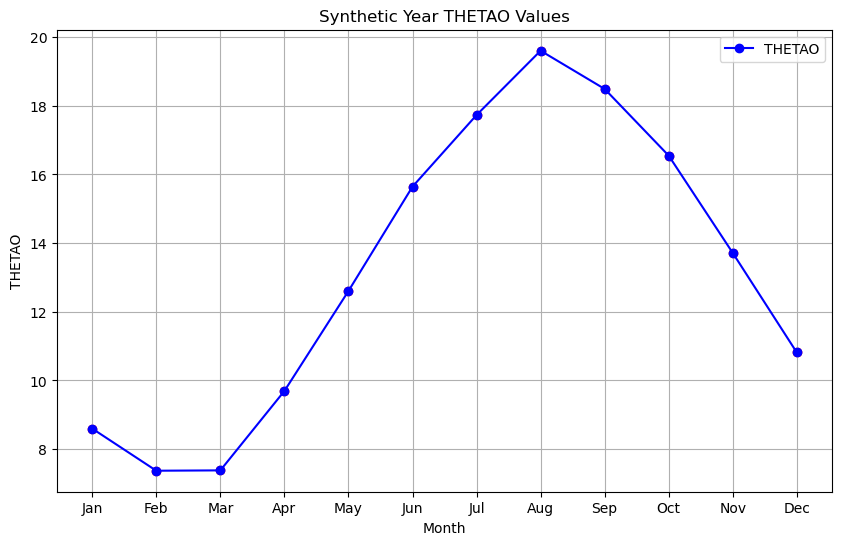

In [153]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(months_order, FS_YEAR, marker='o', linestyle='-', color='b', label=variable)
plt.scatter(months_order, FS_YEAR, color='r')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel(variable)
plt.title(f'Synthetic Year {variable} Values')
plt.grid(True)
plt.legend()
plt.show()

## Synthetic Year Generation

1. ref_ts : this is a list. it is the whole reference timeseries of interest. This code is written based on 2025-2035. The years can be changed.
2. sub_ts : this is a dictionary. The keys are in sub_ts_xxxx, where xxxx refers to the subset year from the reference timeseries. The values are for the variables of the file.
3. monthly_data : this is a dictionary. it contains the data for each month, in a separate key:value pair. for instance, Jan key has the values of all {VARIABLE} for all januaries in the timeseries. This dictionary is useful for intra-month calculation of statistics and metrics.
4. monthly_stats : this is a dictionary which contains the mean, median, standard deviation and 'most probable' value for that month.
5. synthetic_year_mean, synthetic_year_median, synthetic_year_most_probable : these are lists that contain values from monthly_stats to form synthetic years

In [154]:
# Initialize a dictionary to hold lists for each month
monthly_data = {
    'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': [],
    'Jun': [], 'Jul': [], 'Aug': [], 'Sep': [], 'Oct': [],
    'Nov': [], 'Dec': []
}

datavalue = variable #variable name, of the value column

# Extract and store data for each month across all years
for year in range(startyear, endyear + 1):
    for month in range(1, 13):  # From January (1) to December (12)
        month_subset = data[(data['Date'].dt.year == year) & (data['Date'].dt.month == month)]
        month_name = month_subset['Date'].dt.strftime('%b').iloc[0] 
        
        # Append values from a specific column to the correct list
        if not month_subset.empty:
            monthly_data[month_name].extend(month_subset[datavalue].tolist())  # Adjust 'DataValue' to your specific column

# Initialize a dictionary to hold the statistics
monthly_stats = {}

# Calculate statistics and plot histograms
for month, values in monthly_data.items():
    if values:  # Ensure there are values to calculate statistics
        mean_val = np.mean(values)
        median_val = np.median(values)
        std_dev_val = np.std(values)
        
        # Calculate the most probable value using histogram binning
        hist, bin_edges = np.histogram(values, bins='auto')
        max_bin_index = np.argmax(hist)
        most_probable_val = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
        
        # Store the statistics in the dictionary
        monthly_stats[month] = {
            'mean': mean_val,
            'median': median_val,
            'most_probable': most_probable_val,
            'std_dev': std_dev_val
        }

# Initialize lists to hold the synthetic years
synthetic_year_mean = []
synthetic_year_median = []
synthetic_year_most_probable = []

# Create synthetic years using the statistics from monthly_stats
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month in months_order:
    if month in monthly_stats:
        synthetic_year_mean.append(monthly_stats[month]['mean'])
        synthetic_year_median.append(monthly_stats[month]['median'])
        synthetic_year_most_probable.append(monthly_stats[month]['most_probable'])
    else:
        synthetic_year_mean.append(np.nan)
        synthetic_year_median.append(np.nan)
        synthetic_year_most_probable.append(np.nan)

SY_MEAN = synthetic_year_mean
SY_MEDIAN = synthetic_year_median
SY_MP = synthetic_year_most_probable


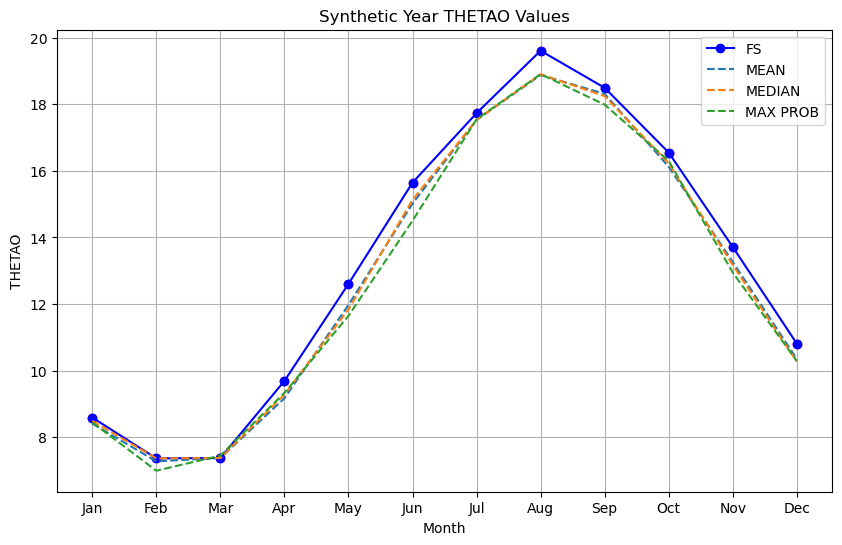

In [155]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(months_order, FS_YEAR, marker='o', linestyle='-', color='b', label='FS')
plt.plot(months_order, SY_MEAN, linestyle='--', label='MEAN')
plt.plot(months_order, SY_MEDIAN, linestyle='--', label='MEDIAN')
plt.plot(months_order, SY_MP, linestyle='--', label='MAX PROB')
plt.scatter(months_order, FS_YEAR,  color='r')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel(variable)
plt.title(f'Synthetic Year {variable} Values')
plt.grid(True)
plt.legend()
plt.show()

## The following snippets are for comparing a Synthetic Year with a TMY generated from FS method

In [156]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.stats import spearmanr


In [157]:
# Function to calculate maximum cross-correlation
def max_cross_correlation(x, y):
    correlation = correlate(x - np.mean(x), y - np.mean(y))
    return np.max(correlation) / (len(x) * np.std(x) * np.std(y))

# Function to calculate Mean Squared Error
def mse(observed, simulated):
    return np.mean((simulated - observed) ** 2)

# Function to calculate Mean Absolute Error
def mae(observed, simulated):
    return np.mean(np.abs(simulated - observed))

def rmse(observed, simulated):
    return np.sqrt(np.mean((simulated - observed) ** 2))

def euclidean_distance(observed, simulated):
    return np.linalg.norm(simulated - observed)


SY_MP_np = np.array(SY_MP)
FS_np = np.array(FS_YEAR)

# Calculate RMSE and Euclidean Distance

rms_e =  rmse(SY_MP_np, FS_np)
euc_d = euclidean_distance(SY_MP_np, FS_np) 
print(f"RMSE: {rms_e:.7f}")
print(f"Euclidean Distance: {euc_d:.7f}")

# Calculate Cosine Similarity
cosine_sim = cosine_similarity([FS_YEAR], [SY_MP])[0][0]
print(f"Cosine Similarity: {cosine_sim:.4f}")

# Calculate Maximum Cross-Correlation
max_corr_year1 = max_cross_correlation(FS_YEAR, SY_MP)
print(f"Max Cross-Correlation: {max_corr_year1:.4f}")


# Calculate MSE
mse_ = mse(SY_MP_np, FS_np)

# Calculate MAE
mae_ = mae(SY_MP_np, FS_np)
print(f"MSE: {mse_:.7f}")
print(f"MAE: {mae_:.7f}")

# Calculate Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(FS_YEAR, SY_MP)
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Calculate Spearman Rank Correlation
spearman_corr, _ = spearmanr(FS_YEAR, SY_MP)
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

RMSE: 0.5934444
Euclidean Distance: 2.0557518
Cosine Similarity: 0.9997
Max Cross-Correlation: 0.9971
MSE: 0.3521763
MAE: 0.4988622
Pearson Correlation: 0.9971
Spearman Rank Correlation: 1.0000
